# N starvation 

## Which N sources allow MED4 to grow

check out Escher visualization https://escher.readthedocs.io/en/latest/getting_started.html

In [317]:
import pandas as pd
import matplotlib.pyplot as plt
import cobra
import numpy as np
import seaborn as sns
import itertools
from matplotlib.colors import LogNorm, Normalize


In [318]:
import subprocess
import time
import os

In [319]:
from cobra.flux_analysis import flux_variability_analysis
from cobra.flux_analysis import production_envelope


In [320]:
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)

In [321]:
RNA_dpath =os.path.join('data', 'RNASEQ') 
os.listdir(RNA_dpath)

['HOT1A3_DE_genes_DESEQ_wKEGG.csv',
 'MED4_DE_DESEQ_results.csv',
 'MED4_DE_genes_DESEQ_wKEGG.csv',
 'MED4_counts_combined.txt',
 'MED4_PMM2locus.csv']

In [322]:
pmm_df = pd.read_csv(os.path.join(RNA_dpath, 'MED4_PMM2locus.csv'), names=['gene_id', 'pmm'])


In [323]:
deseq_df = pd.read_csv(os.path.join(RNA_dpath, 'MED4_DE_genes_DESEQ_wKEGG.csv'))


In [324]:
sns.hls_palette

<function seaborn.palettes.hls_palette(n_colors=6, h=0.01, l=0.6, s=0.65, as_cmap=False)>

In [325]:
# values from Ofaim at el.

PARAMETER_VALUES = [#"Name",     "Reaction ID",          "Lower bound", "UpperBound"
                   ["HCO3",      "HCO3EXcar",            -8,            0],
                   #["Nitrogen",  "AmmoniaEX",            -0.56,         0],
                   #["Phosphate", "FAKEOrthophosphateEX", -0.1,          0],
                   ["Light",     "LightEX",              -150,          0]]
CO2MAX = 0.82

# Block fake reactions
FAKE_TRANSPORT = ["AminosugarsOUT", "FAKEAAOUT", "FAKEABPOUT", "FAKEacpTRANS", "FAKEApoacpTRANS", "FAKEThioredoxinTRANS", 
                  "FreefattyacidsOUT", "7NMeth7carbOUT", "ArtificialproteinOUT", "FADOUT", "LipoylproteinTRANS", "MenaquinoneOUT", 
                  "NicotinateOUT", "THFpolyglutOUT", "Thiamin_dpOUT"]


In [326]:
def get_elements(rid):
    r = model.reactions.get_by_id(rid)
    m = r.reactants[0]    
    elements = m.elements.copy()
    
    res = {
        'reaction' : rid,
        'metabolite' : m.name,
        'N' : 'N' in elements,
        'C' : 'C' in elements,
        
    }
    return res

# Import model and manipulate based on Ofaim at el

In [327]:
import os
model_dpath = os.path.join('..', 'Model_files')
model_fname = 'iSO595v7.xml'
model_fpath = os.path.join(model_dpath, model_fname)


In [328]:
model = cobra.io.read_sbml_model(model_fpath)

In [329]:
# manipulations copied from Ofaim at el.

remove_blocked = False

# Block H2S
model.reactions.H2SEX.lower_bound = 0

# Block fake transports
for rid in FAKE_TRANSPORT:
    model.reactions.get_by_id(rid).bounds = (0,0)

# Remove blocked reactions
if remove_blocked:
    blocked = cobra.flux_analysis.find_blocked_reactions(model, open_exchanges = True)
    print('blocked', len(blocked), blocked)
    model.remove_reactions([model.reactions.get_by_id(r_id) for r_id in blocked])

# Block maximum CO2 production
model.reactions.CO2EX.bounds = (0, CO2MAX)

for i, row in enumerate(PARAMETER_VALUES):
    # Row: Name, Reaction ID, lower bound, upper bound
    key = row[0]
    reaction_id = row[1]
    lower_bound = row[2]
    upper_bound = row[3]
    r = model.reactions.get_by_id(reaction_id)
    # Fix flux
    r.bounds = (lower_bound, upper_bound)

In [330]:
exchange_ids = [r.id for r in model.exchanges] # + ["R00024"]

In [331]:
print('reactions', len(model.reactions))
print('metabolites', len(model.metabolites))
print('genes', len(model.genes))

reactions 994
metabolites 802
genes 595


In [332]:
model

Name,COBRAModel
Memory address,0x07fa50529e040
Number of metabolites,802
Number of reactions,994
Number of groups,55
Objective expression,1.0*BIOMASS - 1.0*BIOMASS_reverse_69053
Compartments,"Cytoplasm, Extracellular, unknownCompartment2, Periplasm, unknownCompartment5"


In [333]:
model.reactions.get_by_id('BIOMASS')

Reaction identifier,BIOMASS
Name,Biomass formation
Memory address,0x7fa50506a340
Stoichiometry,104.0 ATP[c] + 0.0324116276714271 BioPool[c] + 0.0268408791654006 Bmineral[c] + 0.0559910868023904 Cell_wall[c] + 0.00111921401802897 Free_nucleic_acids[c] + 104.0 H2O[c] + 0.649245416793275... 104.0 ATP + 0.0324116276714271 BioPool + 0.0268408791654006 Trace metals and minerals + 0.0559910868023904 Cell wall Biomass precursor + 0.00111921401802897 Free nucleic acids + 104.0 H2O +...
GPR,
Lower bound,0.0
Upper bound,1000.0


In [334]:
fpath = 'PRO_N_sources.xlsx'
df_growing = pd.read_excel(fpath, sheet_name='uptake')
n_exchange_df = pd.read_excel(fpath, sheet_name='secretion')


# Knockout genes - to find genes required for uptake/secretion

### Partition genes and reactions to essential and non-essential

In [ ]:
# open all potential mediums and run gene knockout to see what is blocking growth when all N sources are available 
with model:
    medium = model.medium
    medium["AmmoniaEX"] = 0.0
    for i in df_growing.uptake:
        medium[i] = 1000.0
    model.medium = medium
    model.reactions.BIOMASS.lower_bound = 1e-5
    solution = model.optimize()
    print(model.summary())
    essential_gene_df = single_gene_deletion(model, processes=10)
    print('done genes')
    essential_reaction_df = single_reaction_deletion(model, processes=10)



In [ ]:
essential_gene_df.loc[~essential_gene_df.status.isin(['optimal'])]

In [ ]:
essential_reaction_df.loc[~essential_reaction_df.status.isin(['optimal'])]

In [ ]:
non_essential_genes = set().union(*essential_gene_df.loc[essential_gene_df.status.isin(['optimal']), 'ids'].values)

In [ ]:
non_essential_reactions = set().union(*essential_reaction_df.loc[essential_reaction_df.status.isin(['optimal']), 'ids'].values)

In [ ]:
len(non_essential_genes), len(non_essential_reactions)

In [ ]:
essential_gene_df.to_csv(os.path.join('data', 'MED4_essential_genes.csv'))
essential_reaction_df.to_csv(os.path.join('data', 'MED4_essential_reactions.csv'))


In [362]:
essential_gene_df = pd.read_csv(os.path.join('data', 'MED4_essential_genes.csv'))
essential_reaction_df = pd.read_csv(os.path.join('data', 'MED4_essential_reactions.csv'))


In [363]:
essential_gene_df['gid']  = essential_gene_df.ids.str.extract(r"([^\{\}\']+)")
essential_reaction_df['rid']  = essential_reaction_df.ids.str.extract(r"([^\{\}\']+)")


# Double knockdowns

Some of the genes removed by double knockout are clearly related to uptake. So decided to avoid doing double knockdowns

In [336]:
essential_gene_df.loc[essential_gene_df.growth > 1e-5].ids

1      {'PMM0786'}
4      {'PMM0874'}
5      {'PMM1150'}
7      {'PMM0149'}
9      {'PMM0914'}
          ...     
588    {'PMM1062'}
589    {'PMM0445'}
590    {'PMM0389'}
591    {'PMM1450'}
592    {'PMM1569'}
Name: ids, Length: 309, dtype: object

In [364]:
essential_genes_list = essential_gene_df.loc[essential_gene_df.status.isin(['infeasible']) | 
                      (essential_gene_df.growth<=1e-5)]['gid']

In [365]:
essential_genes_list

0      PMM0572
2      PMM0287
3      PMM0494
6      PMM0243
8      PMM1582
        ...   
581    PMM0526
583    PMM0318
585    PMM1630
593    PMM0671
594    PMM0131
Name: gid, Length: 286, dtype: object

In [366]:
#non_essential_genes = [g.id for g in model.genes if g.id not in essential_combined_genes_set]
non_essential_genes = [g.id for g in model.genes if g.id not in essential_genes_list]


In [368]:
non_essential_reactions = essential_reaction_df.loc[
    essential_reaction_df.status.isin(['optimal']) & 
    (essential_reaction_df.growth > 1e-5) &
    (~essential_reaction_df.rid.isin(exchange_ids))
    , 'rid']
non_essential_reactions

0             R09250
1             R00963
2             R12063
3             R01773
4             R03051
           ...      
982           R10645
987           R05810
988           R05226
990           R00510
993    tRNAFormation
Name: rid, Length: 579, dtype: object

In [369]:
len(non_essential_reactions), len(non_essential_genes)

(579, 595)

In [370]:
with open(os.path.join('data', 'MED4_del_gene_list.txt'), 'w') as fh:
    fh.writelines(f'{i}\n' for i in non_essential_genes)
with open(os.path.join('data', 'MED4_del_reaction_list.txt'), 'w') as fh:
    fh.writelines(f'{i}\n' for i in non_essential_reactions)


### Try to delete genes and reactions and see what is breaking the model per uptake option

In [371]:
with open(os.path.join('data', 'MED4_del_gene_list.txt')) as fh:
    non_essential_genes = [i.rstrip() for i in fh.readlines()]
    
with open(os.path.join('data', 'MED4_del_reaction_list.txt')) as fh:
    non_essential_reactions = [i.rstrip() for i in fh.readlines()]
        

In [372]:
def _uptake_deletion_feeding_with_timeout(dpath, uptake1, deltype, timeout=10):
    try:
        print (uptake1)
        list_file = os.path.join('data', f'MED4_del_{deltype}_list.txt')
            
        result = subprocess.run([
            './prochlorococcus_feed_knockout.py', 
            '--uptake', uptake1, 
            '--out_dpath', dpath,
            '--deltype', deltype,
            '--list_file', list_file,
            ],
            capture_output=True, text=True, check=True, timeout=timeout,
        )
        #print("stdout:", result.stdout)
        #print("stderr:", result.stderr)
        return 'success'
        
    except subprocess.CalledProcessError as err:
        print('CalledProcessError', err.returncode)
        print("stdout:", err.stdout)
        print("stderr:", err.stderr)
        return 'error'
                
    except subprocess.TimeoutExpired as err:
        print('TimeoutExpired', err.timeout)
        print("stdout:", err.stdout)
        print("stderr:", err.stderr)
        return 'timeout'



In [372]:
def _secretion_deletion_feeding_with_timeout(dpath, uptake1, deltype, timeout=10):
    try:
        print (uptake1)
        list_file = os.path.join('data', f'MED4_del_{deltype}_list.txt')
            
        result = subprocess.run([
            './prochlorococcus_feed_knockout.py', 
            '--uptake', uptake1, 
            '--out_dpath', dpath,
            '--deltype', deltype,
            '--list_file', list_file,
            ],
            capture_output=True, text=True, check=True, timeout=timeout,
        )
        #print("stdout:", result.stdout)
        #print("stderr:", result.stderr)
        return 'success'
        
    except subprocess.CalledProcessError as err:
        print('CalledProcessError', err.returncode)
        print("stdout:", err.stdout)
        print("stderr:", err.stderr)
        return 'error'
                
    except subprocess.TimeoutExpired as err:
        print('TimeoutExpired', err.timeout)
        print("stdout:", err.stdout)
        print("stderr:", err.stderr)
        return 'timeout'



In [373]:
deltype = 'gene'
dpath = os.path.join('data',f'{deltype}_knockout_uptake_29082022')
knockout_success = [
    _uptake_deletion_feeding_with_timeout(dpath, u, deltype, timeout=20)
    for u in df_growing.uptake
]


GuanosineEX
TimeoutExpired 20
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nGuanosineEX None Objective\n=========\n1.0 BIOMASS = 1.23944740203336\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number  C-Flux\n         Cadmium[e]            CadmiumEX 5.982E-05         0   0.00%\n  Calcium_cation[e]            CalciumEX   0.03317         0   0.00%\n    Chloride_ion[e]           ChlorideEX    0.2949         0   0.00%\n      Cobalt_ion[e]             CobaltEX  0.001923         0   0.00%\n          Copper[e]             CopperEX 0.0001083         0   0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX    0.4503         0   0.00%\n       Guanosine[e]          GuanosineEX     48.05         0   0.00%\n            HCO3[e]            HCO3EXcar         8         1 100.00%\n             Fe2[e]               IronEX  0.004006         0   0.00%\n          Photon[e]              LightEX    0.2252  

TimeoutExpired 20
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_CystineEX None Objective\n=========\n1.0 BIOMASS = 0.11645172899918435\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 5.621E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX  0.003117         0  0.00%\n    Chloride_ion[e]           ChlorideEX    0.0277         0  0.00%\n      Cobalt_ion[e]             CobaltEX 0.0001807         0  0.00%\n          Copper[e]             CopperEX 1.017E-05         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.04231         0  0.00%\n            HCO3[e]            HCO3EXcar     5.459         1 64.04%\n             Fe2[e]               IronEX 0.0003764         0  0.00%\n       L_Cystine[e]          L_CystineEX     0.511         6 35.96%\n          Photon[e]              LightEX     77.06         0  0.00%\nMa

TimeoutExpired 20
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_GlutamateEX None Objective\n=========\n1.0 BIOMASS = 0.09726135236073205\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.694E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX  0.002603         0  0.00%\n    Chloride_ion[e]           ChlorideEX   0.02314         0  0.00%\n      Cobalt_ion[e]             CobaltEX 0.0001509         0  0.00%\n          Copper[e]             CopperEX 8.495E-06         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.03534         0  0.00%\n            HCO3[e]            HCO3EXcar     5.334         1 41.94%\n             Fe2[e]               IronEX 0.0003143         0  0.00%\n     L_Glutamate[e]        L_GlutamateEX     1.477         5 58.06%\n          Photon[e]              LightEX     82.63         0  0.00%\n

In [380]:
knockout_success

['timeout', 'success', 'success', 'success', 'success', 'success']

In [375]:
df_growing['gknockout_success1'] = knockout_success
df_growing['gknockout_success1'].value_counts()

timeout    9
success    7
Name: gknockout_success1, dtype: int64

In [382]:
deltype = 'gene'
dpath = os.path.join('data',f'{deltype}_knockout_uptake_29082022')
knockout_success = [
    _uptake_deletion_feeding_with_timeout(dpath, u, deltype, timeout=1000)
    for u in df_growing.loc[df_growing.gknockout_success2.isin(['timeout']), 'uptake']
]


L_GlutamineEX
L_SerineEX


KeyboardInterrupt: 

In [381]:
df_growing.loc[df_growing.gknockout_success2.isin(['timeout']), 'gknockout_success3'] = knockout_success
df_growing['gknockout_success3'].value_counts()

success    5
timeout    1
Name: gknockout_success3, dtype: int64

In [383]:
deltype = 'reaction'
dpath = os.path.join('data',f'{deltype}_knockout_uptake_29082022')
knockout_success = [
    _uptake_deletion_feeding_with_timeout(dpath, u, deltype, timeout=26)
    for u in df_growing.uptake
]


GuanosineEX
L_AspartateEX
GlutathioneEX
L_GlutamineEX
L_SerineEX
TimeoutExpired 26
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_SerineEX None Objective\n=========\n1.0 BIOMASS = 0.1189721893957353\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 5.742E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX  0.003184         0  0.00%\n    Chloride_ion[e]           ChlorideEX    0.0283         0  0.00%\n      Cobalt_ion[e]             CobaltEX 0.0001846         0  0.00%\n          Copper[e]             CopperEX 1.039E-05         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.04322         0  0.00%\n            HCO3[e]            HCO3EXcar     5.475         1  8.04%\n               H[e]                  HEX     4.669         0  0.00%\n             Fe2[e]               IronEX 0.0003845         0  0.00%\n        

CyanateEX
TimeoutExpired 26
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nCyanateEX None Objective\n=========\n1.0 BIOMASS = 0.08817277250778842\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.256E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX   0.00236         0  0.00%\n    Chloride_ion[e]           ChlorideEX   0.02098         0  0.00%\n      Cobalt_ion[e]             CobaltEX 0.0001368         0  0.00%\n          Copper[e]             CopperEX 7.701E-06         0  0.00%\n         Cyanate[e]            CyanateEX    0.7658         1 12.68%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.03203         0  0.00%\n            HCO3[e]            HCO3EXcar     5.275         1 87.32%\n             Fe2[e]               IronEX  0.000285         0  0.00%\n          Photon[e]              LightEX     71.18         0  0

In [388]:
knockout_success

['timeout', 'success', 'success', 'success']

In [385]:
df_growing['rknockout_success1'] = knockout_success
df_growing['rknockout_success1'].value_counts()

success    12
timeout     4
Name: rknockout_success1, dtype: int64

In [390]:
deltype = 'reaction'
dpath = os.path.join('data',f'{deltype}_knockout_uptake_29082022')
knockout_success = [
    _uptake_deletion_feeding_with_timeout(dpath, u, deltype, timeout=60)
    for u in df_growing.loc[df_growing.rknockout_success2.isin(['timeout']), 'uptake']
]


L_SerineEX


In [389]:
df_growing.loc[df_growing.rknockout_success1.isin(['timeout']), 'rknockout_success2'] = knockout_success
df_growing['rknockout_success2'].value_counts()

success    3
timeout    1
Name: rknockout_success2, dtype: int64

In [391]:
knockout_success

['success']

# Double gene/reaction deletion - for now not running

# Results of knockdown

### load the knockout results

In [668]:
deltype = 'gene'
dpath = os.path.join('data',f'{deltype}_knockout_uptake_29082022')
gene_uptake_knockout_df = pd.concat([pd.read_csv(os.path.join(dpath, i)) for i in os.listdir(dpath)])

In [669]:
deltype = 'reaction'
dpath = os.path.join('data',f'{deltype}_knockout_uptake_29082022')
reaction_uptake_knockout_df = pd.concat([pd.read_csv(os.path.join(dpath, i)) for i in os.listdir(dpath)])

In [670]:
reaction_uptake_knockout_df['rid']  = reaction_uptake_knockout_df.ids.str.extract(r"([^\{\}\']+)")
gene_uptake_knockout_df['gid']  = gene_uptake_knockout_df.ids.str.extract(r"([^\{\}\']+)")


In [671]:
reaction_uptake_knockout_df['reaction'] = reaction_uptake_knockout_df.rid.map(lambda x: model.reactions.get_by_id(x).name)

In [672]:
model.genes.PMM0001.id

'PMM0001'

In [673]:
def _get_gene_ids(rid):
    gids = model.reactions.get_by_id(rid).genes
    return pd.Series({'gid' :[g.id for g in gids]})

reaction_uptake_knockout_df['gid'] = reaction_uptake_knockout_df.rid.apply(_get_gene_ids)

In [674]:
gene_uptake_knockout_df

,Unnamed: 0,ids,growth,status,uptake,secretion,gid
0,0,{'PMM0951'},NaN,infeasible,L_GlutamateEX,NaN,PMM0951
1,1,{'PMM0796'},NaN,infeasible,L_GlutamateEX,NaN,PMM0796
2,3,{'PMM0483'},NaN,infeasible,L_GlutamateEX,NaN,PMM0483
3,5,{'PMM0001'},0.00001,optimal,L_GlutamateEX,NaN,PMM0001
4,7,{'PMM1181'},NaN,infeasible,L_GlutamateEX,NaN,PMM1181
...,...,...,...,...,...,...,...
320,589,{'PMM0938'},NaN,infeasible,L_SerineEX,NaN,PMM0938
321,590,{'PMM1472'},NaN,infeasible,L_SerineEX,NaN,PMM1472
322,591,{'PMM1273'},NaN,infeasible,L_SerineEX,NaN,PMM1273
323,592,{'PMM0723'},NaN,infeasible,L_SerineEX,NaN,PMM0723


In [675]:
gids_of_reactions_df = reaction_uptake_knockout_df.explode('gid')
gids_of_reactions_df = gids_of_reactions_df.dropna(subset=['gid'], axis=0)

In [676]:
gids_of_reactions_df = gids_of_reactions_df.drop_duplicates(subset=['uptake', 'gid'])

In [677]:
cols = gids_of_reactions_df.columns

In [678]:
# remove genes that are already knocked out
gids_of_reactions_df_m = pd.merge(gids_of_reactions_df, gene_uptake_knockout_df, how='left',
                                  suffixes=['', '_test'], on=['uptake', 'gid'])
gids_of_reactions_df = gids_of_reactions_df_m.loc[gids_of_reactions_df_m.ids_test.isna(), cols]

In [679]:
gene_uptake_knockout_df['knockout'] = 'gene'
gids_of_reactions_df['knockout'] = 'reaction'


In [680]:
gene_uptake_knockout_df = pd.concat([gene_uptake_knockout_df, gids_of_reactions_df])

In [681]:
deseq_df.columns

Index(['gene_id', 'gene', 'product', 'status', 'main', 'sub', 'path', 'ecpath',
       'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj',
       'contrast', 'Length', 'organism', 'protein_id'],
      dtype='object')

In [682]:
gene_uptake_knockout_df = pd.merge(gene_uptake_knockout_df, pmm_df, left_on='gid', right_on='pmm', how='left')

In [683]:
cols = ['gene_id', 'gene', 'product', 'status', 'sub', 'path', 'ecpath',
       'baseMean', 'log2FoldChange',  'padj',
       ]
gene_uptake_knockout_df = pd.merge(gene_uptake_knockout_df, deseq_df[cols], on='gene_id', 
         how='left', suffixes=['', '_de'])

In [684]:
gene_uptake_knockout_df.head()

,Unnamed: 0,ids,growth,status,uptake,secretion,gid,knockout,rid,reaction,...,pmm,gene,product,status_de,sub,path,ecpath,baseMean,log2FoldChange,padj
0,0,{'PMM0951'},NaN,infeasible,L_GlutamateEX,NaN,PMM0951,gene,NaN,NaN,...,PMM0951,carA,glutamine-hydrolyzing carbamoyl-phosphate synt...,down,09104 Nucleotide metabolism // 09105 Amino aci...,00240 Pyrimidine metabolism [PATH:ko00240] // ...,"K01956 carA, CPA1; carbamoyl-phosphate syntha...",178.513724,-1.504660,1.544491e-08
1,1,{'PMM0796'},NaN,infeasible,L_GlutamateEX,NaN,PMM0796,gene,NaN,NaN,...,PMM0796,hisA,1-(5-phosphoribosyl)-5-[(5-phosphoribosylamino...,no_significant,09105 Amino acid metabolism,00340 Histidine metabolism [PATH:ko00340],K01814 hisA; phosphoribosylformimino-5-aminoi...,284.786091,0.285050,2.226182e-01
2,3,{'PMM0483'},NaN,infeasible,L_GlutamateEX,NaN,PMM0483,gene,NaN,NaN,...,PMM0483,hemL,"glutamate-1-semialdehyde 2,1-aminomutase",no_significant,09108 Metabolism of cofactors and vitamins // ...,00860 Porphyrin metabolism [PATH:ko00860] // 0...,"K01845 hemL; glutamate-1-semialdehyde 2,1-ami...",2468.751490,0.459796,1.200598e-01
3,5,{'PMM0001'},0.00001,optimal,L_GlutamateEX,NaN,PMM0001,gene,NaN,NaN,...,PMM0001,dnaN,DNA polymerase III subunit beta,no_significant,09124 Replication and repair // 09182 Protein ...,03030 DNA replication [PATH:ko03030] // 03430 ...,K02338 dnaN; DNA polymerase III subunit beta ...,1548.906501,0.228545,4.619685e-01
4,7,{'PMM1181'},NaN,infeasible,L_GlutamateEX,NaN,PMM1181,gene,NaN,NaN,...,PMM1181,aroH,chorismate mutase,down,09105 Amino acid metabolism,"00400 Phenylalanine, tyrosine and tryptophan b...",K06208 aroH; chorismate mutase [EC:5.4.99.5],195.838847,-1.247608,8.508785e-09


In [685]:
gpdf = gene_uptake_knockout_df.pivot_table(index='gene',columns='uptake', values='status', aggfunc='count', fill_value=0)

In [686]:
rpdf = reaction_uptake_knockout_df.loc[
    ~reaction_uptake_knockout_df.rid.isin(exchange_ids)
].pivot_table(index='reaction',columns='uptake', values='status', aggfunc='count', fill_value=0)

In [687]:
gene_uptake_knockout_df.groupby('ids').size().value_counts()

16    289
9      37
1      31
14     26
15     17
2       5
13      3
10      1
dtype: int64

Text(3.4929999999999986, 0.5, 'number of gene knockouts')

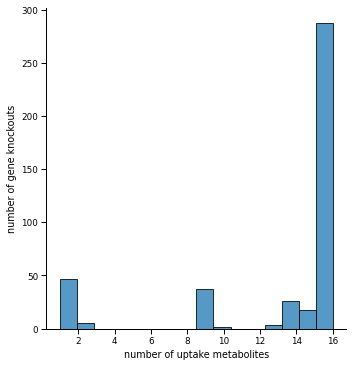

In [688]:
sns.displot(gene_uptake_knockout_df.groupby('gid').size(), bins=16)
plt.xlabel('number of uptake metabolites')
plt.ylabel('number of gene knockouts')


Text(9.117999999999999, 0.5, 'number of reaction knockouts')

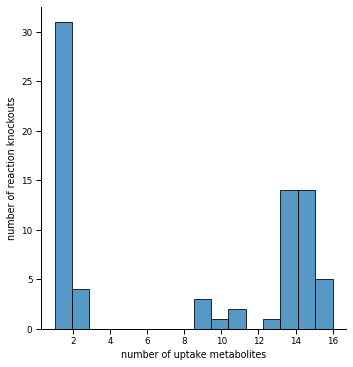

In [689]:
sns.displot(reaction_uptake_knockout_df.groupby('rid').size(), bins=16)
plt.xlabel('number of uptake metabolites')
plt.ylabel('number of reaction knockouts')


In [690]:
gene_uptake_knockout_df.columns

Index(['Unnamed: 0', 'ids', 'growth', 'status', 'uptake', 'secretion', 'gid',
       'knockout', 'rid', 'reaction', 'gene_id', 'pmm', 'gene', 'product',
       'status_de', 'sub', 'path', 'ecpath', 'baseMean', 'log2FoldChange',
       'padj'],
      dtype='object')

In [692]:
gene_uptake_knockout_df['knockout'].value_counts()

gene        5648
reaction      18
Name: knockout, dtype: int64

In [693]:
gpdf = gene_uptake_knockout_df.pivot_table(index='gene',columns='uptake', values='log2FoldChange', aggfunc='mean',
                                           fill_value=0)


In [694]:
gene_uptake_knockout_df['stars'] = ''
gene_uptake_knockout_df.loc[gene_uptake_knockout_df.padj < 0.1, 'stars'] = '*'
gene_uptake_knockout_df.loc[gene_uptake_knockout_df.padj < 0.05, 'stars'] = '**'
gene_uptake_knockout_df.loc[gene_uptake_knockout_df.padj < 0.01, 'stars'] = '***'


In [695]:
gene_uptake_knockout_df.groupby( ['gene','uptake'] ).size().reset_index().nlargest(columns=0, n=20)


,gene,uptake,0
3339,cysK,AmmoniaEX,2
3340,cysK,CyanateEX,2
3341,cysK,GlutathioneEX,2
3342,cysK,GlycineEX,2
3343,cysK,GuanineEX,2
3344,cysK,GuanosineEX,2
3345,cysK,L_AlanineEX,2
3346,cysK,L_ArginineEX,2
3347,cysK,L_AspartateEX,2
3348,cysK,L_CystineEX,2


In [696]:
gpdf_padj = gene_uptake_knockout_df.pivot_table(index='gene',columns='uptake', values='stars', aggfunc='first',
                                           fill_value='')


In [697]:
gene_uptake_knockout_df.head()

,Unnamed: 0,ids,growth,status,uptake,secretion,gid,knockout,rid,reaction,...,gene,product,status_de,sub,path,ecpath,baseMean,log2FoldChange,padj,stars
0,0,{'PMM0951'},NaN,infeasible,L_GlutamateEX,NaN,PMM0951,gene,NaN,NaN,...,carA,glutamine-hydrolyzing carbamoyl-phosphate synt...,down,09104 Nucleotide metabolism // 09105 Amino aci...,00240 Pyrimidine metabolism [PATH:ko00240] // ...,"K01956 carA, CPA1; carbamoyl-phosphate syntha...",178.513724,-1.504660,1.544491e-08,***
1,1,{'PMM0796'},NaN,infeasible,L_GlutamateEX,NaN,PMM0796,gene,NaN,NaN,...,hisA,1-(5-phosphoribosyl)-5-[(5-phosphoribosylamino...,no_significant,09105 Amino acid metabolism,00340 Histidine metabolism [PATH:ko00340],K01814 hisA; phosphoribosylformimino-5-aminoi...,284.786091,0.285050,2.226182e-01,
2,3,{'PMM0483'},NaN,infeasible,L_GlutamateEX,NaN,PMM0483,gene,NaN,NaN,...,hemL,"glutamate-1-semialdehyde 2,1-aminomutase",no_significant,09108 Metabolism of cofactors and vitamins // ...,00860 Porphyrin metabolism [PATH:ko00860] // 0...,"K01845 hemL; glutamate-1-semialdehyde 2,1-ami...",2468.751490,0.459796,1.200598e-01,
3,5,{'PMM0001'},0.00001,optimal,L_GlutamateEX,NaN,PMM0001,gene,NaN,NaN,...,dnaN,DNA polymerase III subunit beta,no_significant,09124 Replication and repair // 09182 Protein ...,03030 DNA replication [PATH:ko03030] // 03430 ...,K02338 dnaN; DNA polymerase III subunit beta ...,1548.906501,0.228545,4.619685e-01,
4,7,{'PMM1181'},NaN,infeasible,L_GlutamateEX,NaN,PMM1181,gene,NaN,NaN,...,aroH,chorismate mutase,down,09105 Amino acid metabolism,"00400 Phenylalanine, tyrosine and tryptophan b...",K06208 aroH; chorismate mutase [EC:5.4.99.5],195.838847,-1.247608,8.508785e-09,***


In [698]:
gene_uptake_knockout_df['sub'].drop_duplicates().str.split(' // ', 
                                         expand=True).melt().dropna()['value'].value_counts()

09105 Amino acid metabolism                                 33
09181 Protein families: metabolism                          32
09101 Carbohydrate metabolism                               27
09102 Energy metabolism                                     22
09183 Protein families: signaling and cellular processes    21
09108 Metabolism of cofactors and vitamins                  20
09104 Nucleotide metabolism                                 18
09106 Metabolism of other amino acids                       15
09103 Lipid metabolism                                      12
09107 Glycan biosynthesis and metabolism                    10
09110 Biosynthesis of other secondary metabolites           10
09132 Signal transduction                                   10
09182 Protein families: genetic information processing       9
09175 Drug resistance: antimicrobial                         6
09111 Xenobiotics biodegradation and metabolism              6
09109 Metabolism of terpenoids and polyketides         

In [699]:
gene_uptake_knockout_df['sub'].str.split(' // ', 
                                         expand=True).melt().dropna()['value'].value_counts()

09108 Metabolism of cofactors and vitamins                  1509
09105 Amino acid metabolism                                 1279
09181 Protein families: metabolism                          1140
09102 Energy metabolism                                      964
09101 Carbohydrate metabolism                                646
09104 Nucleotide metabolism                                  642
09183 Protein families: signaling and cellular processes     627
09182 Protein families: genetic information processing       415
09103 Lipid metabolism                                       336
09106 Metabolism of other amino acids                        300
09107 Glycan biosynthesis and metabolism                     289
09110 Biosynthesis of other secondary metabolites            286
09109 Metabolism of terpenoids and polyketides               282
09131 Membrane transport                                     232
09124 Replication and repair                                 192
09132 Signal transduction

In [756]:
kegg_categories_map = {
    '09183 Protein families: signaling and cellular processes' : 'Signal/cellular',
    '09132 Signal transduction' : 'Signal/cellular',                                
    '09193 Unclassified: signaling and cellular processes' : 'Signal/cellular',
    '09143 Cell growth and death' : 'Signal/cellular',                              
    #'09132 Signal transduction': 'Signal transduction',
    '09109 Metabolism of terpenoids and polyketides' : 'Secondary',
    '09182 Protein families: genetic information processing' : 'genetic info',
    '09110 Biosynthesis of other secondary metabolites' : 'Secondary', 
    '09108 Metabolism of cofactors and vitamins': 'Secondary',
    '09102 Energy metabolism' : 'Energy',
    '09101 Carbohydrate metabolism': 'Carbohydrate',
    '09104 Nucleotide metabolism' : 'Nucleotide',
    '09105 Amino acid metabolism' : 'Amino acid',
    '09106 Metabolism of other amino acids' : 'Amino acid',
    #'09143 Cell growth and death', 'Cell growth and death',
    #'09123 Folding, sorting and degradation' : 'Folding'
    #'09141 Transport and catabolism' : ''
#09124 Replication and repair                                 12
    #'09131 Membrane transport' : 'Membrane transport',
    '09103 Lipid metabolism' : 'Lipid',
    '09107 Glycan biosynthesis and metabolism' : 'Glycan',
}


In [757]:
deseq_df.columns

Index(['gene_id', 'gene', 'product', 'status', 'main', 'sub', 'path', 'ecpath',
       'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj',
       'contrast', 'Length', 'organism', 'protein_id'],
      dtype='object')

In [758]:
kegg_rowanno = deseq_df[['sub', 'log2FoldChange']]
kegg_rowanno.index= deseq_df['gene']
kegg_rowanno = kegg_rowanno[~kegg_rowanno.index.duplicated(keep='first')]
kegg_rowanno = kegg_rowanno.loc[gpdf.index,:]
#kegg_rowanno = kegg_rowanno.to_frame(name='cat')

In [759]:
kegg_rowanno.columns

Index(['sub', 'log2FoldChange'], dtype='object')


for i, j in kegg_categories_map.items():
    kegg_rowanno[j] = kegg_rowanno.cat.str.contains(i)

In [760]:
kegg_rowanno['sub'] = kegg_rowanno['sub'].fillna('')
for i, j in kegg_categories_map.items():
    kegg_rowanno.loc[kegg_rowanno['sub'].str.contains(i), 'Category']  = j
kegg_rowanno.loc[kegg_rowanno['Category'].isna(), 'Category']  = 'Other'
    

In [761]:
kegg_rowanno.Category.value_counts()

Amino acid         90
Secondary          88
Energy             67
Signal/cellular    33
Other              32
Nucleotide         31
Carbohydrate       23
Lipid              21
genetic info       19
Glycan             19
Name: Category, dtype: int64

In [762]:
kegg_rowanno.loc[kegg_rowanno.Category.isin(['Other']), 'sub'].str.split(' // ', 
                                         expand=True).melt().dropna()['value'].value_counts()

                                      24
09191 Unclassified: metabolism         6
09194 Poorly characterized             1
09181 Protein families: metabolism     1
Name: value, dtype: int64

In [763]:
kegg_rowanno_sorted = kegg_rowanno.sort_values(by=['Category', 'log2FoldChange' ], ascending=[True, False])

In [764]:
gpdf_sorted = gpdf.reindex(kegg_rowanno_sorted.index)
gpdf_padj_sorted = gpdf_padj.reindex(kegg_rowanno_sorted.index)


In [765]:
cl_labels = kegg_rowanno.Category.unique()
cl_labels.sort()

lut = dict(zip(cl_labels, sns.color_palette(palette='Set1', n_colors=len(cl_labels))))
row_anno = kegg_rowanno_sorted.Category.map(lut)

Text(0.5, 1, 'med4 uptake gene knockouts')

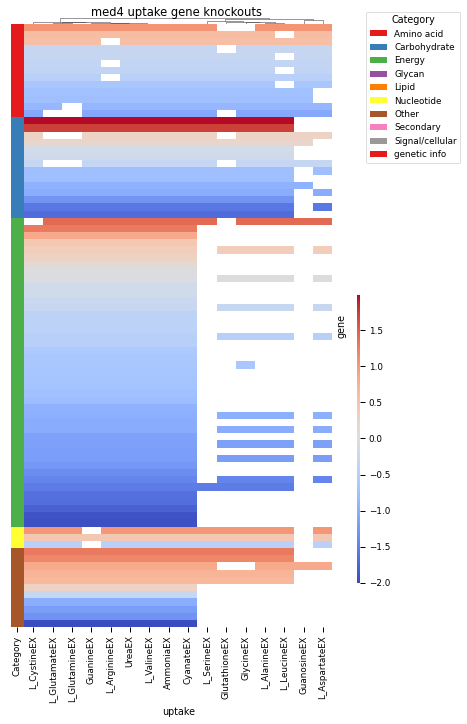

In [766]:
from matplotlib.patches import Patch
sel = ((gpdf != 0).sum(axis=1) >8) & ((gpdf != 0).sum(axis=1) < gpdf.shape[1])
sns.clustermap(data=gpdf_sorted.loc[sel], 
               mask=(gpdf_sorted.loc[sel] == 0),
               #annot=gpdf_padj_sorted.loc[sel], fmt='',
               row_colors=row_anno.loc[sel],
               figsize=(5,10), lw=0.001, cmap='coolwarm', center=0,
              colors_ratio=0.04, 
               dendrogram_ratio=0.01,
               linecolor='lightgrey',
               row_cluster=False,
               cbar_pos=(1, .2, .01, .4),
               yticklabels=False,
              )

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Category',
           bbox_to_anchor=(1.3, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.suptitle('med4 uptake gene knockouts', y=1)

Text(0.5, 1, 'med4 uptake gene knockouts')

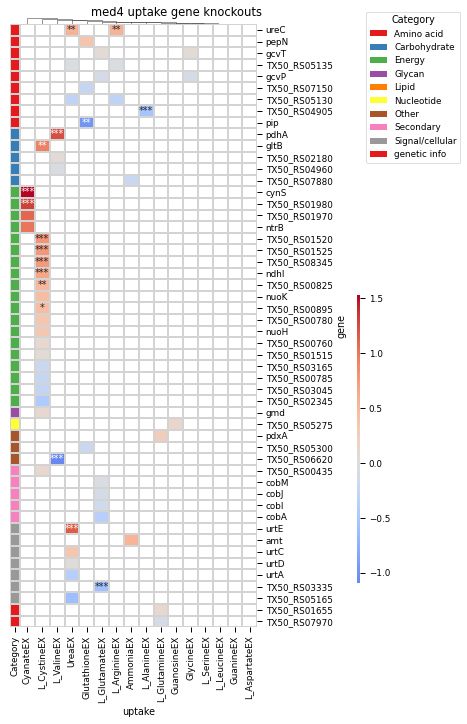

In [768]:
from matplotlib.patches import Patch
sel = (gpdf != 0).sum(axis=1) <=8
sns.clustermap(data=gpdf_sorted.loc[sel], 
               mask=(gpdf_sorted.loc[sel] == 0),
               annot=gpdf_padj_sorted.loc[sel], fmt='',
               row_colors=row_anno.loc[sel],
               figsize=(5,10), lw=0.01, cmap='coolwarm', center=0,
              colors_ratio=0.04, 
               dendrogram_ratio=0.01,
               linecolor='lightgrey',
               row_cluster=False,
               cbar_pos=(1, .2, .01, .4),
              )

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Category',
           bbox_to_anchor=(1.3, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.suptitle('med4 uptake gene knockouts', y=1)

Text(0.5, 1, 'med4 uptake reaction knockouts')

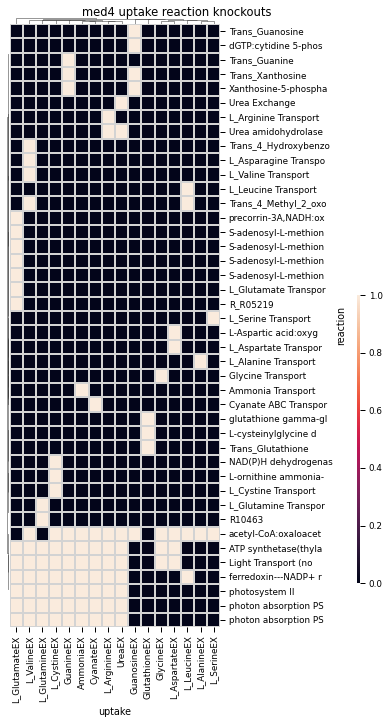

In [722]:
sel = rpdf.sum(axis=1)< 14
sns.set_context('paper')
sns.clustermap(data=rpdf.loc[sel], 
               yticklabels= rpdf.loc[sel].index.str.slice(0, 20),
               figsize=(5,10), lw=0.01,
               dendrogram_ratio=0.01,
               linecolor='lightgrey',
               cbar_pos=(1, .2, .01, .4),
#                 #cmap='coolwarm',
#                row_cluster=False,
              )




plt.suptitle('med4 uptake reaction knockouts', y=1)

In [774]:
from openpyxl import load_workbook

fpath = 'data/PRO_N_sources.xlsx'

book = load_workbook(fpath)
writer = pd.ExcelWriter(fpath, engine = 'openpyxl')
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

gene_uptake_knockout_df.to_excel(writer, sheet_name = 'gene_knockout_uptake')
reaction_uptake_knockout_df.to_excel(writer, sheet_name = 'reactin_knockout_uptake')
#writer.save()
writer.close()

In [769]:
n_exchange_df.head()                          

,Unnamed: 0,secretion,minimum,maximum,uptake,metabolite_uptake,N_uptake,C_uptake,metabolite_secretion,N_secretion,C_secretion
0,0,B12EX,0.000000,7.941910,GuanosineEX,Guanosine[e],False,False,Cobamide coenzyme,True,True
1,1,BiotinEX,0.000000,1.985477,GuanosineEX,Guanosine[e],False,False,Biotin,True,True
2,2,MethanolEX,0.000042,1.985519,GuanosineEX,Guanosine[e],False,False,Methanol,False,True
3,3,SAdenosyl4methylthio2oxobutanoateEX,0.000042,1.985519,GuanosineEX,Guanosine[e],False,False,S-Adenosyl-4-methylthio-2-oxobutanoate,True,True
4,4,SMethyl5thioDriboseEX,0.000000,15.884229,GuanosineEX,Guanosine[e],False,False,S-Methyl-5-thio-D-ribose,False,True


In [770]:
n_exchange_df.shape

(881, 11)

In [ ]:
tdf = n_exchange_df
dpath = 'gene_knockout_secreted_18082022'
knockout_success = [
    _gene_deletion_feeding_with_timeout(dpath, u, s, m, timeout=10)
    for (u, s, m) in zip(tdf['uptake'], tdf['secretion'], tdf['maximum'])
]


In [ ]:
tdf = n_exchange_df.loc[n_exchange_df.knockout_success1 == 'timeout']
dpath = 'gene_knockout_secreted_18082022'
knockout_success = [
    _gene_deletion_feeding_with_timeout(dpath, u, s, m, timeout=20)
    for (u, s, m) in zip(tdf['uptake'], tdf['secretion'], tdf['maximum'])
]


In [ ]:
len(knockout_success)

n_exchange_df.loc[n_exchange_df.knockout_success1 == 'timeout', 'knockout_success2'] = knockout_success

In [ ]:
n_exchange_df.loc[
    n_exchange_df.knockout_success1 != 'timeout', 'knockout_success2'
] = n_exchange_df.loc[
    n_exchange_df.knockout_success1 != 'timeout', 'knockout_success1'
]

In [ ]:
n_exchange_df.knockout_success2.value_counts()

In [ ]:
tdf = n_exchange_df.loc[n_exchange_df.knockout_success2 == 'timeout']
dpath = 'gene_knockout_secreted_18082022'
knockout_success = [
    _gene_deletion_feeding_with_timeout(dpath, u, s, m, timeout=20)
    for (u, s, m) in zip(tdf['uptake'], tdf['secretion'], tdf['maximum'])
]


In [ ]:
len(knockout_success)

n_exchange_df.loc[n_exchange_df.knockout_success2 == 'timeout', 'knockout_success3'] = knockout_success

In [ ]:
n_exchange_df.loc[
    n_exchange_df.knockout_success2 != 'timeout', 'knockout_success3'
] = n_exchange_df.loc[
    n_exchange_df.knockout_success2 != 'timeout', 'knockout_success2'
]

In [ ]:
n_exchange_df.knockout_success3.value_counts()

In [ ]:
tdf = n_exchange_df.loc[n_exchange_df.knockout_success3 != 'success']
dpath = 'gene_knockout_secreted_18082022'
knockout_success = [
    _gene_deletion_feeding_with_timeout(dpath, u, s, m, timeout=20)
    for (u, s, m) in zip(tdf['uptake'], tdf['secretion'], tdf['maximum'])
]


In [ ]:
len(knockout_success)


In [ ]:

n_exchange_df.loc[n_exchange_df.knockout_success3 != 'success', 'knockout_success4'] = knockout_success

In [ ]:
n_exchange_df.loc[
    n_exchange_df.knockout_success3 == 'success', 'knockout_success4'
] = n_exchange_df.loc[
    n_exchange_df.knockout_success3 == 'success', 'knockout_success3'
]

In [ ]:
n_exchange_df.knockout_success4.value_counts()

In [ ]:
dpath = 'gene_knockout_secreted_18082022'
os.listdir(dpath)

In [ ]:
knockout_df = pd.concat([pd.read_csv(os.path.join(dpath, i)) for i in os.listdir(dpath)])

In [ ]:
knockout_df.groupby(['ids','uptake'])['secretion'].count()

In [ ]:
knockout_df.groupby(['ids'])['secretion'].count().nlargest(30)

In [ ]:
knockout_df.pivot_table(index=['ids'], columns=['secretion'], aggfunc='count', values='uptake')

In [ ]:
knockout_df.pivot_table(index=['ids'], columns=['uptake'], aggfunc='count', values='secretion')

In [ ]:
n_exchange_df.secretion.nunique()